## Практическое задание 6. Градиентный бустинг ~~своими руками~~

Поздравляю! Это финальное упражнение в нашем курсе. Проявите все своё старание, терпение и опыт, чтобы выполнить его.  
Теперь вы многое знаете из машинного обучения и для вас не составит сложности попробовать разные алгоритмы, новые библиотеки и применить их к реальной задаче.

__Задание 1. (0.5 балла)__

Мы будем использовать данные соревнования [Home Credit Default Risk](https://www.kaggle.com/c/home-credit-default-risk/data).  

* Загрузите таблицу **application_train.csv**;
* Запишите в Y столбец с целевой переменной;
* Удалите ненужные столбцы (для этого воспользуйтесь описанием);
* Определите тип столбцов и заполните пропуски - стратегия произвольная;
* Разбейте выборку в соотношении 70:30 с random_state=0.

Так как в данных значительный дисбаланс классов, в качестве метрики качества везде будем использовать площадь под precision-recall кривой.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("application_train.csv")
data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
Y = data['TARGET']

In [4]:
data.drop('SK_ID_CURR', axis=1, inplace=True)
data.drop('TARGET', axis=1, inplace=True)
data.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
def transform_data(data):
    columns = data.select_dtypes(include=['object']).columns
    data[columns] = data[columns].fillna('nan')
    columns = data.select_dtypes(include=['int64', 'float64']).columns
    data[columns] = data[columns].fillna(0)
    return data
data = transform_data(data)

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, Y, train_size=0.7, random_state=0)

__Задание 2. (1.5 балла)__

Также мы будем использовать две реализации градиентного бустинга: [LightGBM](https://lightgbm.readthedocs.io/en/stable/Python-API.html) и [Catboost](https://catboost.ai/en/docs/), которые вам необходимо самостоятельно изучить и установить, используя команды:  
`!pip install lightgb`  
`!pip install catboost`  
Обучите реализации градиентного бустинга LightGBM и Catboost на вещественных признаках без подбора параметров. 
Почему получилась заметная разница в качестве? 

В этом и последующих экспериментах необходимо измерять время обучения моделей.

In [8]:
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import average_precision_score
import time

In [9]:
df = data.copy()
df = df.select_dtypes(include=['int64', 'float64'])
X_train, X_test, y_train, y_test = train_test_split(df, Y, train_size=0.7, random_state=0)

In [10]:
def best_parametrs(model, param_grid, X_train, y_train):

    gridsearch = GridSearchCV(model, param_grid, scoring='average_precision', cv=3)
    t0 = time.time()
    gridsearch.fit(X_train, y_train)
    t1 = time.time()
    return gridsearch.best_params_, t1 - t0

In [11]:
def metric(model, X_train, X_test, y_train, y_test):
    t0 = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]
    t1 = time.time()
    return average_precision_score(y_test, y_pred), t1 - t0, y_pred

In [12]:
results = pd.DataFrame(index = ['LightGBM', 'CatBoost'], 
                       columns = ['Без параметров', 'С параметрами', 'OHE', 'Встроенная обработка'])

__Обучение LightGBM__

In [13]:
model = LGBMClassifier(verbose=-100)
results.iloc[0, 0], t, _ = metric(model, X_train, X_test, y_train, y_test)

print('LightGBM new:', results.iloc[0, 0])
print('Время выполнения:', t)

LightGBM new: 0.23159230793933594
Время выполнения: 2.429084062576294


__Обучение CatBoost__

In [14]:
model = CatBoostClassifier(logging_level='Silent')
results.iloc[1, 0], t, _ = metric(model, X_train, X_test, y_train, y_test)

print('LightGBM new:', results.iloc[1, 0])
print('Время выполнения:', t)

LightGBM new: 0.23355967132379712
Время выполнения: 30.11463475227356


__Ответ:__ для LightGBM требуется дополнительная настройка гиперпараметров

__Задание 3. (2 балла)__

Подберите с CV=3 оптимальные параметры алгоритмов, изменяя:

* глубину деревьев;
* количество деревьев;
* темп обучения;
* оптимизируемый функционал.

Проанализируйте соотношения глубины и количества деревьев в зависимости от алгоритма.

__Поиск наилучших параметров для LightGBM:__

In [15]:
from sklearn.model_selection import GridSearchCV

param_grid = {
        'max_depth': [2, 4, 6],
        'n_estimators': [100, 500, 1000],
        'learning_rate': [0.01, 0.1, 0.5],
        'objective': ['binary']
}
model = LGBMClassifier(verbose=-100)
bests, t = best_parametrs(model, param_grid, X_train, y_train)
print('best params: ', bests)
print('Время выполнения:', t)

best params:  {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 1000, 'objective': 'binary'}
Время выполнения: 287.8066339492798


In [16]:
model = LGBMClassifier(learning_rate=0.1, max_depth=2, n_estimators=1000, objective='binary', verbose=-100)
results.iloc[0, 1], t, y_lgbm = metric(model, X_train, X_test, y_train, y_test)

print('LightGBM new:', results.iloc[0, 1])
print('Время выполнения:', t)

LightGBM new: 0.2334494228307752
Время выполнения: 5.902567625045776


__Поиск наилучших параметров для CatBoost:__

In [17]:
param_grid = {
    'depth': [2, 4, 6],
    'iterations': [100, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.5],
    'loss_function': ['Logloss']
}

model = CatBoostClassifier(logging_level='Silent')
bests, t = best_parametrs(model, param_grid, X_train, y_train)
print('best params: ', bests)
print('Время выполнения:', t)

best params:  {'depth': 4, 'iterations': 500, 'learning_rate': 0.1, 'loss_function': 'Logloss'}
Время выполнения: 864.2706007957458


In [18]:
model = CatBoostClassifier(learning_rate=0.1, depth=4, iterations=500, loss_function='Logloss', logging_level='Silent')
results.iloc[1, 1], t, y_cat = metric(model, X_train, X_test, y_train, y_test)

print('CatBoost new:', results.iloc[1, 1])
print('Время выполнения:', t)

CatBoost new: 0.2335251857656888
Время выполнения: 12.90478229522705


__Задание 4. (3.5 балла)__

Добавьте категориальные признаки к вещественным следующими способами:

* как OHE признаки;
* как счетчики со сглаживанием.

При подсчете счетчиков запрещается использование циклов. 

На получившихся датасетах подберите параметры у каждого из алгоритмов. Как меняется время, необходимое для обучения модели в зависимости от способа кодирования? Сравните полученные результаты с встроенными методами обработки категориальных признаков. 

In [19]:
from sklearn.preprocessing import OneHotEncoder

In [20]:
cat = data.select_dtypes(include=['object'])

In [21]:
encoder = OneHotEncoder()
encoder_df = pd.DataFrame(encoder.fit_transform(cat).toarray())
df_e = df.join(encoder_df)

In [22]:
df_e

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,136,137,138,139,140,141,142,143,144,145
0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,-2120,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,-291,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,-4260.0,-2531,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,-9833.0,-2437,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,-4311.0,-3458,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,157500.0,254700.0,27558.0,225000.0,0.032561,-9327,-236,-8456.0,-1982,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
307507,0,72000.0,269550.0,12001.5,225000.0,0.025164,-20775,365243,-4388.0,-4090,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
307508,0,153000.0,677664.0,29979.0,585000.0,0.005002,-14966,-7921,-6737.0,-5150,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
307509,0,171000.0,370107.0,20205.0,319500.0,0.005313,-11961,-4786,-2562.0,-931,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [23]:
X_train, X_test, y_train, y_test = train_test_split(df_e, Y, train_size=0.7, random_state=0)

__Поиск наилучших параметров для LightGBM на новых данных:__

In [24]:
param_grid = {
        'max_depth': [2, 4, 6],
        'n_estimators': [100, 500, 1000],
        'learning_rate': [0.01, 0.1, 0.5],
        'objective': ['binary']
}
model = LGBMClassifier(verbose=-100)
bests, t = best_parametrs(model, param_grid, X_train, y_train)
print('best params: ', bests)
print('Время выполнения:', t)

best params:  {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 1000, 'objective': 'binary'}
Время выполнения: 389.3672685623169


In [25]:
model = LGBMClassifier(learning_rate=0.1, max_depth=2, n_estimators=1000, objective='binary', verbose=-100)
results.iloc[0, 2], t, y_lgbm_e  = metric(model, X_train, X_test, y_train, y_test)

print('LightGBM new:', results.iloc[0, 2])
print('Время выполнения:', t)

LightGBM new: 0.24009721126971995
Время выполнения: 7.542213678359985


__Поиск наилучших параметров для CatBoost на новых данных:__

In [26]:
param_grid = {
    'depth': [2, 4, 6],
    'iterations': [100, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.5],
    'loss_function': ['Logloss']
}

model = CatBoostClassifier(logging_level='Silent')
bests, t = best_parametrs(model, param_grid, X_train, y_train)
print('best params: ', bests)
print('Время выполнения:', t)

best params:  {'depth': 4, 'iterations': 500, 'learning_rate': 0.1, 'loss_function': 'Logloss'}
Время выполнения: 892.757082939148


In [27]:
model = CatBoostClassifier(depth=4, iterations=500, learning_rate=0.1, loss_function='Logloss', logging_level='Silent')

results.iloc[1, 2], t, y_cat_e = metric(model, X_train, X_test, y_train, y_test)
print('CatBoost new:', results.iloc[1, 2])
print('Время выполнения:', t)

CatBoost new: 0.2393053600071652
Время выполнения: 12.47759199142456


__Встроенные методы обработки категориальных признаков:__

In [28]:
for c in data.columns:
    col_type = data[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        data[c] = data[c].astype('category')

index = data.select_dtypes(include=['category']).columns
cat = data[index]

cat_labels = np.array(cat.columns)
X_train, X_test, y_train, y_test = train_test_split(data, Y, test_size=0.3, random_state=0)

1. Поиск метрики для LightGBM:

In [29]:
model = LGBMClassifier(categorical_feature=cat_labels, learning_rate=0.1, max_depth=2, n_estimators=1000, 
                       objective='binary',verbose=-100)

results.iloc[0, 3], t, y_lgbm_c  = metric(model, X_train, X_test, y_train, y_test)

print('LightGBM new:', results.iloc[0, 3])
print('Время выполнения:', t)

C:\Users\Lenovo\PycharmProjects\pythonProject1\venv\lib\site-packages\lightgbm\basic.py:1873: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
C:\Users\Lenovo\PycharmProjects\pythonProject1\venv\lib\site-packages\lightgbm\basic.py:1893: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


LightGBM new: 0.2376851926221542
Время выполнения: 6.495837926864624


2. Поиск метрики для CatBoost:

In [30]:
model = CatBoostClassifier(depth=4, iterations=500, learning_rate=0.1, loss_function='Logloss', logging_level='Silent')
t0 = time.time()
model.fit(X_train, y_train, cat_features=cat_labels)
y_pred = model.predict_proba(X_test)[:, 1]
t1 = time.time()

results.iloc[1, 3] = average_precision_score(y_test, y_pred)
t = t1 - t0
y_cat_c = y_pred
print('CatBoost new:', results.iloc[1, 3])
print('Время выполнения:', t1 - t0)

CatBoost new: 0.24029611256748595
Время выполнения: 73.64621162414551


__Задание 5. (1 балл)__

Реализуйте блендинг подобранных в предыдущем задании моделей и сравните качество.

In [31]:
y_lgbm_b = (y_lgbm + y_lgbm_e + y_lgbm_c) / 3
y_cat_b = (y_cat + y_cat_e + y_cat_c) / 3

blend = []

blend.append(average_precision_score(y_test, y_lgbm_b))
blend.append(average_precision_score(y_test, y_cat_b))

In [32]:
blend

[0.23967845530759257, 0.24020401988185808]

In [33]:
results['blending'] = blend

In [34]:
results

,Без параметров,С параметрами,OHE,Встроенная обработка,blending
LightGBM,0.231592,0.233449,0.240097,0.237685,0.239678
CatBoost,0.23356,0.233525,0.239305,0.240296,0.240204


__Задание 6. (1.5 балла)__

В задании 3 вы подобрали гиперпараметры для LightGBM и CatBoost на вещественных признаках. Визуализируйте важности признаков, посчитанные этими алгоритмами, в виде горизонтального bar-plot (отсортируйте признаки по убыванию важности, подпишите названия признаков по оси y).

Для каждого из двух алгоритмов удалите неважные признаки (обычно по bar-plot хорошо видно порог на важность, с которого начинается хвост неважных признаков) и обучите ту же модель на получившихся данных. Сильно ли упало качество при удалении признаков, которые модель считает неважными?

1. Для LightGBM

In [35]:
X_train, X_test, y_train, y_test = train_test_split(df, Y, test_size=0.3, random_state=0)

Text(0.5, 1.0, 'Важность признаков LGBM')

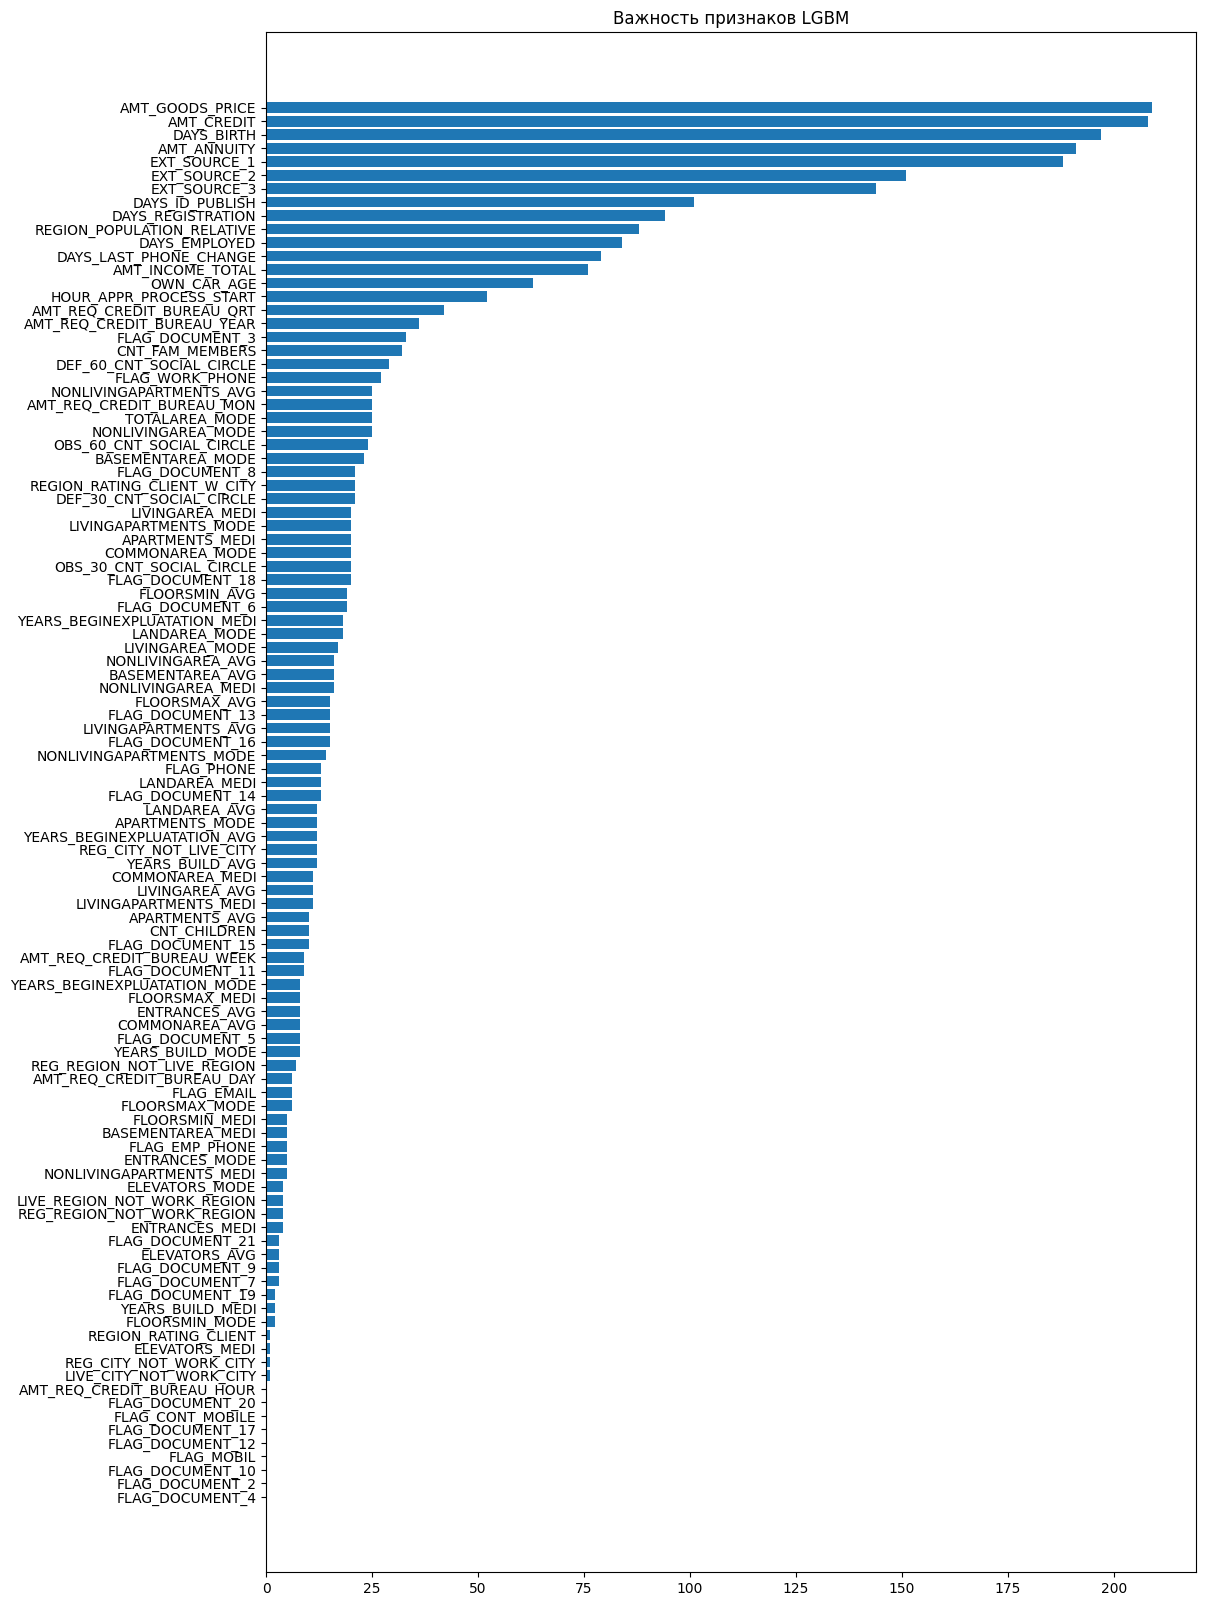

In [36]:
model = LGBMClassifier(learning_rate=0.1, max_depth=2, n_estimators=1000, 
                       objective='binary',verbose=-100)

model.fit(X_train, y_train)

importance_lgbm = model.feature_importances_
ind = np.argsort(importance_lgbm)
importance_lgbm = importance_lgbm[ind]
feature_importance_lgbm = np.array(df.columns[ind])

fig = plt.figure(figsize=(12, 20))
plt.barh(range(len(ind)), importance_lgbm)
plt.yticks(range(len(ind)), feature_importance_lgbm)
plt.title('Важность признаков LGBM')

In [37]:
feature_importance_lgbm = feature_importance_lgbm[79:]
print('Количество главных признаков = ', len(feature_importance_lgbm))

Количество главных признаков =  25


In [38]:
X = df[feature_importance_lgbm]
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.7, random_state=0)

t0 = time.time()
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
t1 = time.time()

res_lgbm = average_precision_score(y_test, y_pred)

print('LGBM:', res_lgbm)
print('Время выполнения:', t1 - t0)

LGBM: 0.23374822390476938
Время выполнения: 3.5685927867889404


2. Для CatBoost

In [39]:
X_train, X_test, y_train, y_test = train_test_split(df, Y, test_size=0.3, random_state=0)

Text(0.5, 1.0, 'Важность признаков CatBoost')

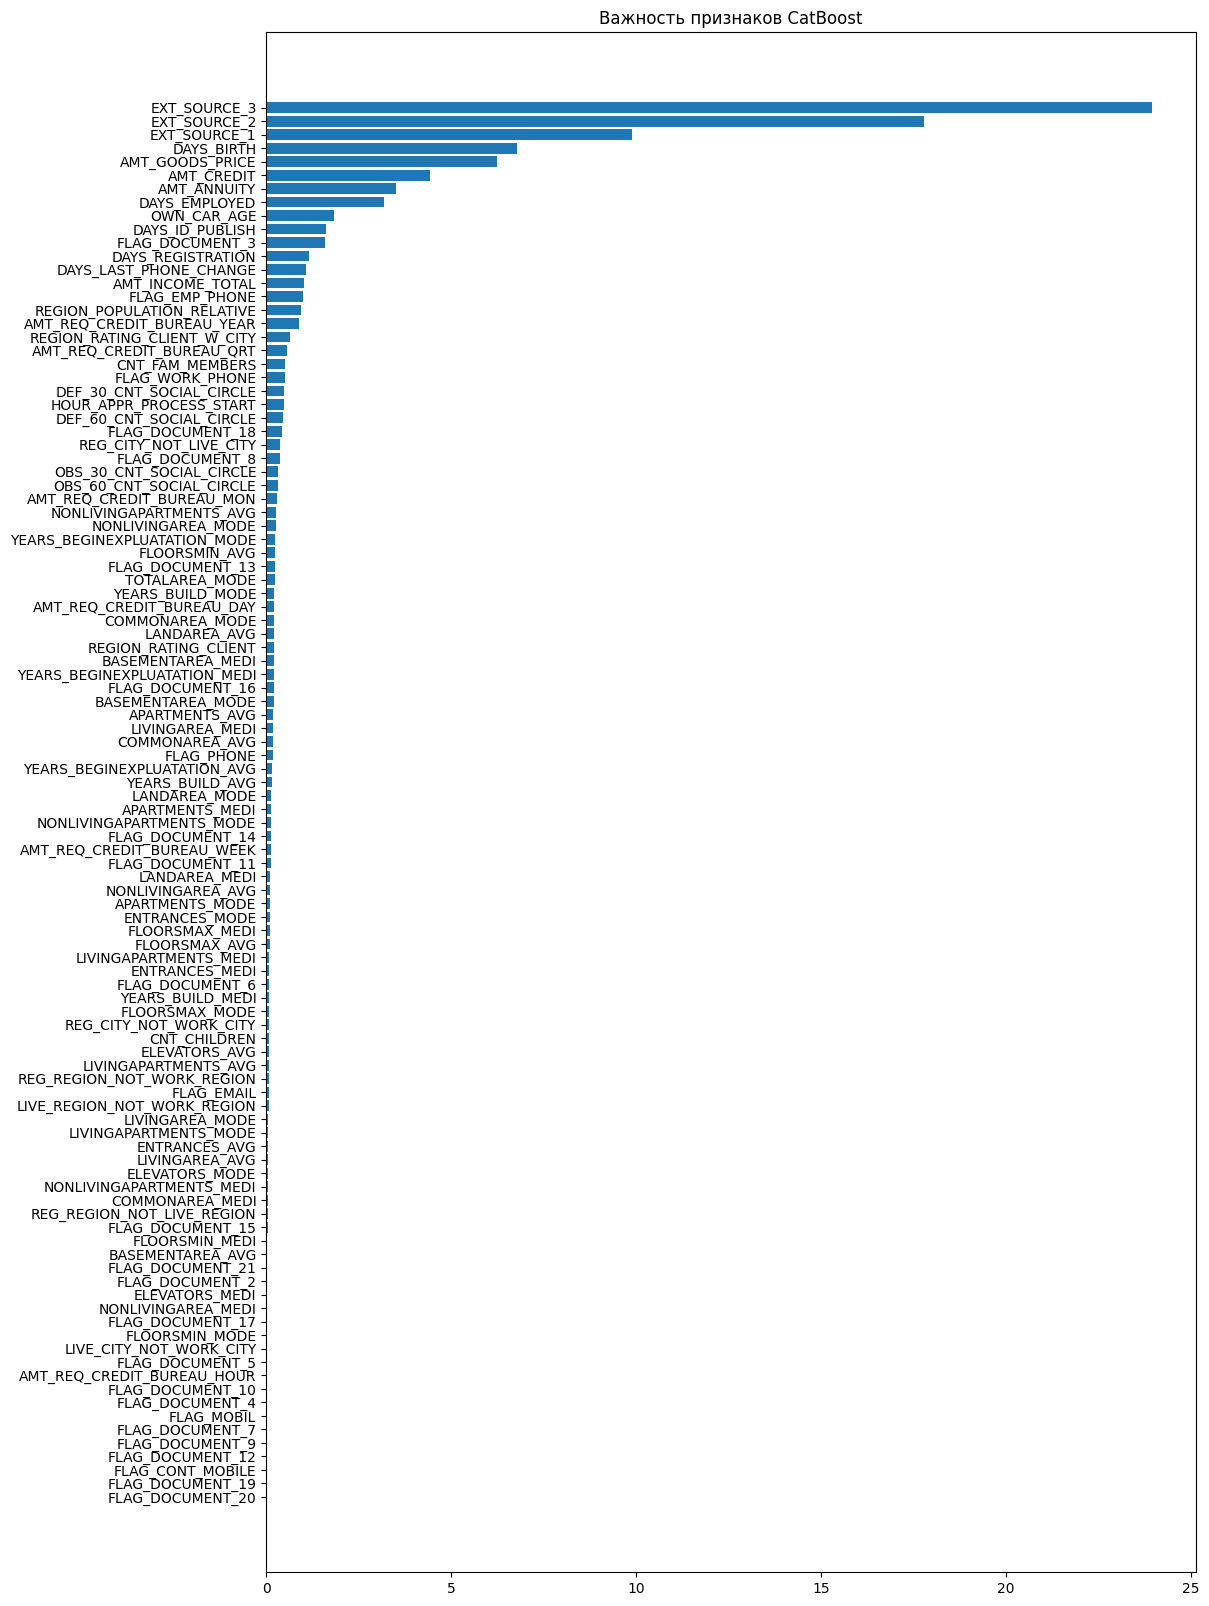

In [40]:
model = CatBoostClassifier(depth=4, iterations=500, learning_rate=0.1, loss_function='Logloss', logging_level='Silent')
model.fit(X_train, y_train)

importance_cat = model.feature_importances_
ind = np.argsort(importance_cat)
importance_cat = importance_cat[ind]
feature_importance_cat = np.array(df.columns[ind])

fig = plt.figure(figsize=(12, 20))
plt.barh(range(len(ind)), importance_cat)
plt.yticks(range(len(ind)), feature_importance_cat)
plt.title('Важность признаков CatBoost')

In [41]:
feature_importance_cat = feature_importance_cat[79:]
print('Количество главных признаков = ', len(feature_importance_cat))

Количество главных признаков =  25


In [42]:
X = df[feature_importance_cat]
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.7, random_state=0)

t0 = time.time()
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
t1 = time.time()

res_cat = average_precision_score(y_test, y_pred)

print('LGBM:', res_cat)
print('Время выполнения:', t1 - t0)

LGBM: 0.23208955572364004
Время выполнения: 8.347231388092041


In [43]:
results1 = pd.DataFrame(index = ['LightGBM','CatBoost'], columns = ['Все признаки', 'Важные признаки'])

results1.iloc[0, 0] = results.iloc[0, 1]
results1.iloc[1, 0] = results.iloc[1, 1]
results1.iloc[0, 1] = res_lgbm
results1.iloc[1, 1] = res_cat

results1

,Все признаки,Важные признаки
LightGBM,0.233449,0.233748
CatBoost,0.233525,0.23209
